## Обучение и построение эмбеддингов для изобраений с одеждой

### 1.1 Выбор датасета

Для обучения эмбединга был выбран датасет DeepFashion, а именно его раздел Consumer-to-shop Clothes Retrieval Benchmark. Этот датасет содержит 239,557 изображений. В этом датасет представлены пары изображений одной и той же одежды: потребительское фото и проффесиональное фото из магазина. Датасет прекарсно подхдит для нашей задачи сопоставления фотографий сделанных пользователями с изображениями из онлайн магазинов. \
Файлы с изображениями находятся в `/img`, файлы с различными аннотациями - в `/Anno`, файл содержащий разбиение на train/test/val выборки соответствий - в `/Eval`

### 1.2 Подготовка датасета к работе

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np
from PIL import Image

In [2]:
DATASET_PATH = "./DeepFashionDataset"
IMG_DIR = os.path.join(DATASET_PATH, "img")
EVAL_FILE = os.path.join(DATASET_PATH, "Eval", "list_eval_partition.txt")

Чтение `Eval/list_eval_partition.txt`

In [3]:
def load_data(file_path):
    data = {"train": [], "test": [], "val": []}

    with open(file_path, "r") as f:
        next(f)
        next(f)
        for line in f:
            img_path1, img_path2, item_id, partition = line.strip().split()
            data[partition].append((img_path1, img_path2, item_id))

    for key in data:
        data[key] = pd.DataFrame(data[key], columns=["image_path1", "image_path2", "category"])

    return data


In [4]:
df = load_data(EVAL_FILE)
df

{'train':                                          image_path1  \
 0       img/TOPS/T_Shirt/id_00000209/comsumer_01.jpg   
 1       img/TOPS/T_Shirt/id_00000209/comsumer_02.jpg   
 2       img/TOPS/T_Shirt/id_00000250/comsumer_01.jpg   
 3       img/TOPS/T_Shirt/id_00000250/comsumer_02.jpg   
 4       img/TOPS/T_Shirt/id_00000299/comsumer_01.jpg   
 ...                                              ...   
 98827  img/DRESSES/Dress/id_00026698/comsumer_01.jpg   
 98828  img/DRESSES/Dress/id_00026698/comsumer_02.jpg   
 98829  img/DRESSES/Dress/id_00026698/comsumer_03.jpg   
 98830  img/DRESSES/Dress/id_00026719/comsumer_01.jpg   
 98831  img/DRESSES/Dress/id_00026719/comsumer_02.jpg   
 
                                      image_path2     category  
 0       img/TOPS/T_Shirt/id_00000209/shop_01.jpg  id_00000209  
 1       img/TOPS/T_Shirt/id_00000209/shop_01.jpg  id_00000209  
 2       img/TOPS/T_Shirt/id_00000250/shop_01.jpg  id_00000250  
 3       img/TOPS/T_Shirt/id_00000250/shop_01

Разбиение на train/test/val

In [5]:
train_df = df["train"]
test_df = df["test"]
val_df = df["val"]

print(f"Train: {train_df.shape[0]}, Test: {test_df.shape[0]}, Validate: {val_df.shape[0]}")

Train: 98832, Test: 47773, Validate: 48935


In [23]:
classes = {}
for i in range(len(train_df)):
    pos_path = train_df.iloc[i]["image_path2"]
    parts = pos_path.split("/")
    base = parts[2]
    if base not in classes:
        classes[base] = 0
    classes[base] += 1

classes

{'T_Shirt': 15258,
 'Summer_Wear': 45308,
 'Dress': 8164,
 'Tank_Top': 3396,
 'Lace_Shirt': 4026,
 'Coat': 6969,
 'Chiffon': 995,
 'Blouse': 597,
 'Pants': 8416,
 'Leggings': 3947,
 'Polo_Shirt': 273,
 'Jeans': 344,
 'Skirt': 999,
 'Suspenders_Skirt': 21,
 'Sleeveless_Dress': 43,
 'Lace_Dress': 76}

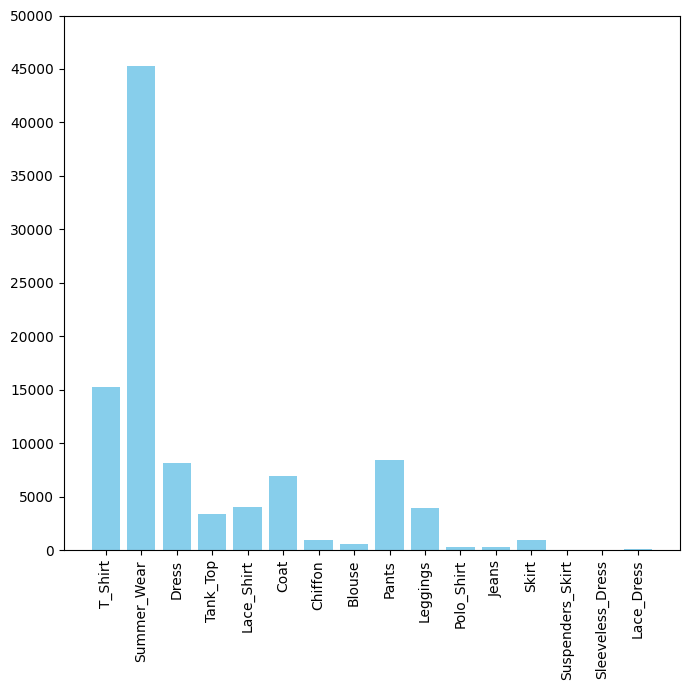

In [30]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7, 7))
plt.bar(classes.keys(), classes.values(), color='skyblue')
plt.yticks(range(0, 50001, 5000))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Будем работать с изображениями 224x224, также дополним датасет следующим:
1. обрезанными изображеиями,
2. изображениями с измененной яркостью на $\pm$50%,
3. изображения с добавленным шумом.

In [31]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return x + self.std * torch.randn_like(x)


transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.3),
    transforms.ToTensor(),
    AddGaussianNoise(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Класс для работы с датасетом

In [32]:
from time import time


class FashionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, random_negative_prob=0.3):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.random_negative_prob = random_negative_prob

        self.base_to_indices = {}
        for i in range(len(df)):
            pos_path = os.path.join(self.img_dir, self.df.iloc[i]["image_path2"])
            parts = pos_path.split("/")
            base = os.path.join(*parts[:3])
            if base not in self.base_to_indices:
                self.base_to_indices[base] = []
            self.base_to_indices[base].append(i)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        anchor_path = os.path.join(self.img_dir, self.df.iloc[idx]["image_path1"])
        positive_path = os.path.join(self.img_dir, self.df.iloc[idx]["image_path2"])
        label = self.df.iloc[idx]["category"]
        
        anchor_parts = anchor_path.split("/")
        base = os.path.join(*anchor_parts[:3])
        anchor_id = anchor_parts[3]

        if np.random.rand() < self.random_negative_prob:
            negative_idx = np.random.choice(len(self.df))
        else:
            candidates = self.base_to_indices.get(base, [])
            negative_idx = np.random.choice(candidates)
            while self.df.iloc[negative_idx]["category"] == self.df.iloc[idx]["category"]:
                negative_idx = np.random.choice(candidates)
        negative_path = os.path.join(self.img_dir, self.df.iloc[negative_idx]["image_path2"])

        anchor = Image.open(anchor_path).convert("RGB")
        positive = Image.open(positive_path).convert("RGB")
        negative = Image.open(negative_path).convert("RGB")
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative, label
    
    def show_samples(self, num_samples=1):
        fig, axes = plt.subplots(num_samples, 6, figsize=(15, 3 * num_samples))
        
        for i in range(num_samples):
            anchor_normalized, positive_normalized, negative_normalized, label = self[i]
            
            mean=[0.485, 0.456, 0.406]
            std=[0.229, 0.224, 0.225]
            mean = torch.tensor(mean).view(3, 1, 1)
            std = torch.tensor(std).view(3, 1, 1)
            
            anchor_denormalized = anchor_normalized * std + mean
            positive_denormalized = positive_normalized * std + mean
            negative_denormalized = negative_normalized * std + mean
            
            anchor_normalized = anchor_normalized.permute(1, 2, 0).numpy()
            anchor_denormalized = anchor_denormalized.permute(1, 2, 0).numpy()

            positive_normalized = positive_normalized.permute(1, 2, 0).numpy()
            positive_denormalized = positive_denormalized.permute(1, 2, 0).numpy()

            negative_normalized = negative_normalized.permute(1, 2, 0).numpy()
            negative_denormalized = negative_denormalized.permute(1, 2, 0).numpy()
            
            axes[i, 0].imshow(anchor_denormalized)
            axes[i, 0].set_title("anchor")
            
            axes[i, 1].imshow(anchor_normalized)
            axes[i, 1].set_title("anchor normalized")

            axes[i, 2].imshow(positive_denormalized)
            axes[i, 2].set_title("positive")

            axes[i, 3].imshow(positive_normalized)
            axes[i, 3].set_title("positive normalized")

            axes[i, 4].imshow(negative_denormalized)
            axes[i, 4].set_title("negative")

            axes[i, 5].imshow(negative_normalized)
            axes[i, 5].set_title("negative normalized")
        plt.show()

In [33]:
import torch.multiprocessing as mp
mp.set_start_method('fork', force=True)


train_dataset = FashionDataset(train_df, DATASET_PATH, transform)
test_dataset = FashionDataset(test_df, DATASET_PATH, transform)
val_dataset = FashionDataset(val_df, DATASET_PATH, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15061584..0.99861217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7081063..2.5808356].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12530646..1.0168854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6324406..2.4132168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15262905..1.1958201].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.712735..3.4144816].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.204

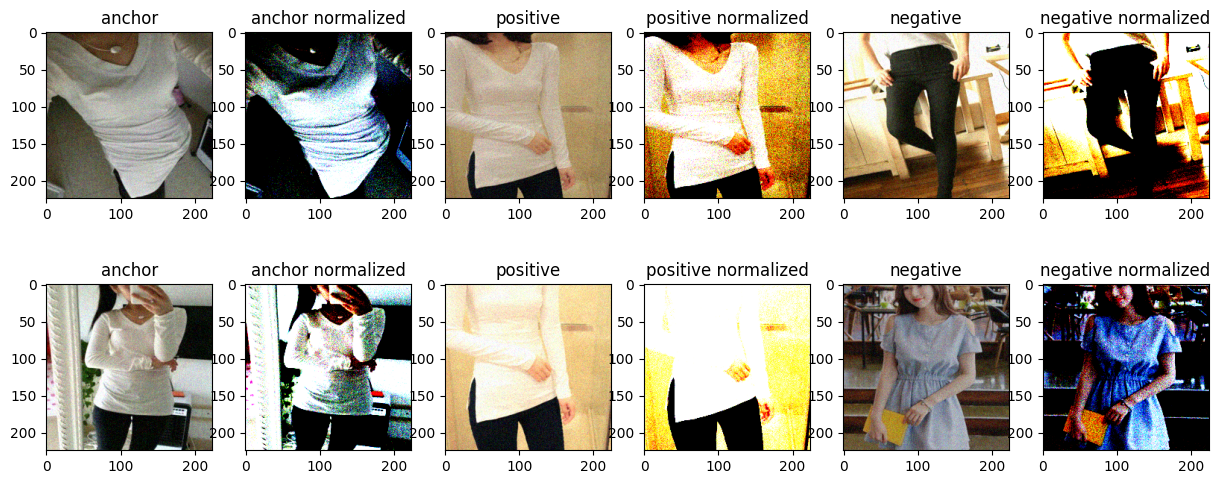

In [133]:
train_dataset.show_samples(2)

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn import TripletMarginLoss


class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

In [37]:
from torchvision.models import ResNet50_Weights


class ResNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=128, name="embedding_model"):
        super(ResNetEmbedding, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(2048, embedding_dim)
        self.name = name

    def forward(self, x):
        return self.resnet(x)


embedding_model = ResNetEmbedding(embedding_dim=128, name="triplet_loss_trained")

In [38]:
device = torch.device("cuda")
# loss_function = TripletLoss()
loss_function = TripletMarginLoss()
num_epochs = 20

In [39]:
import torch.optim as optim

optimizer = optim.Adam(embedding_model.parameters(), lr=0.0001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

In [40]:
from tqdm import tqdm
import wandb


def fit(embedding_model, num_epochs, optimizer, scheduler, loss_function, train_loader, 
        saving_path='embedding_checkpoints', start_epoch=1, loading_path=None):
    os.makedirs(saving_path, exist_ok=True)

    wandb.init(project="embedding_training", config={
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "optimizer": optimizer.__class__.__name__,
        "loss_function": loss_function.__class__.__name__
    })
    
    embedding_model.to(device)

    if loading_path and os.path.exists(loading_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        embedding_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Checkpoint loaded: {checkpoint_path}, starting from epoch {start_epoch}")
    
    for epoch in range(start_epoch, num_epochs + 1):
        embedding_model.train()
        total_loss = 0.0
        
        for anchor, positive, negative, label in train_loader:  
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            optimizer.zero_grad()
            anchor_emb = embedding_model(anchor)
            positive_emb = embedding_model(positive)
            negative_emb = embedding_model(negative)
            
            loss = loss_function(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() / len(train_loader)
            
            wandb.log({"batch_loss": loss.item()})

        scheduler.step()
        print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss:.6f}")
        wandb.log({"epoch_loss": total_loss, "epoch": epoch})
        
        checkpoint_path = os.path.join(saving_path, f"{embedding_model.name}_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': embedding_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': total_loss
        }, checkpoint_path)
        print(f"✅ Model saved: {checkpoint_path}")


In [19]:
fit(embedding_model, num_epochs, optimizer, lr_scheduler, loss_function, train_loader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: originalno43 (originalno43-hse-pokra) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/20, Loss: 0.195955
✅ Model saved: embedding_checkpoints/triplet_loss_trained_1.pth
Epoch 2/20, Loss: 0.114344
✅ Model saved: embedding_checkpoints/triplet_loss_trained_2.pth
Epoch 3/20, Loss: 0.100100
✅ Model saved: embedding_checkpoints/triplet_loss_trained_3.pth
Epoch 4/20, Loss: 0.085090
✅ Model saved: embedding_checkpoints/triplet_loss_trained_4.pth
Epoch 5/20, Loss: 0.078952
✅ Model saved: embedding_checkpoints/triplet_loss_trained_5.pth
Epoch 6/20, Loss: 0.071512
✅ Model saved: embedding_checkpoints/triplet_loss_trained_6.pth
Epoch 7/20, Loss: 0.063305
✅ Model saved: embedding_checkpoints/triplet_loss_trained_7.pth
Epoch 8/20, Loss: 0.059527
✅ Model saved: embedding_checkpoints/triplet_loss_trained_8.pth
Epoch 9/20, Loss: 0.051861
✅ Model saved: embedding_checkpoints/triplet_loss_trained_9.pth
Epoch 10/20, Loss: 0.048427
✅ Model saved: embedding_checkpoints/triplet_loss_trained_10.pth
Epoch 11/20, Loss: 0.044573
✅ Model saved: embedding_checkpoints/triplet_loss_trained_11

In [41]:
def evaluate_model(embedding_model, loss_function, loader):
    total_loss = 0.0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Testing")
        for anchor, positive, negative, label in progress_bar:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_emb = embedding_model(anchor)
            positive_emb = embedding_model(positive)
            negative_emb = embedding_model(negative)

            loss = loss_function(anchor_emb, positive_emb, negative_emb)
            total_loss += loss.item() / len(loader)

            progress_bar.set_postfix(loss=f"{loss.item():.6f}")

    print(f"✅ Testing completed. Avg Loss: {total_loss:.6f}")
    return total_loss

In [42]:
avg_losses_test_epoch_20 = 0
checkpoint = torch.load("embedding_checkpoints/triplet_loss_trained_20.pth", map_location=device)
embedding_model.load_state_dict(checkpoint['model_state_dict'])
embedding_model.to(device)
embedding_model.eval()
avg_loss_test_epoch_20 = evaluate_model(embedding_model, loss_function, test_loader)
avg_loss_test_epoch_20

/tmp/ipykernel_267801/2185708818.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("embedding_checkpoints/triplet_loss_trained_20.pth", map_locatio

✅ Testing completed. Avg Loss: 0.089038


0.08903771886973569

In [18]:
models_dir = "embedding_checkpoints"
model = ResNetEmbedding(embedding_dim=128, name="triplet_loss_trained")

avg_losses_test = []

for epoch in range(1, num_epochs + 1):
    checkpoint_path = os.path.join(models_dir, f"{model.name}_{epoch}.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
        print(f"✅ Checkpoint loaded: {checkpoint_path}")
    else:
        print(f"🔞 No checkpoint path: {checkpoint_path}")
        break
    
    epoch_loss_test = evaluate_model(model, loss_function, test_loader)
    avg_losses_test.append(epoch_loss_test)
    

/tmp/ipykernel_213323/2304025061.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_1.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.410900]


✅ Testing completed. Avg Loss: 0.170145
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_2.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.105726]


✅ Testing completed. Avg Loss: 0.149613
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_3.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.26it/s, loss=0.487410]


✅ Testing completed. Avg Loss: 0.135915
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_4.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.296216]


✅ Testing completed. Avg Loss: 0.139420
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_5.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.25it/s, loss=0.265819]


✅ Testing completed. Avg Loss: 0.138061
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_6.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.24it/s, loss=0.017013]


✅ Testing completed. Avg Loss: 0.125450
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_7.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.24it/s, loss=0.012089]


✅ Testing completed. Avg Loss: 0.119787
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_8.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.000000]


✅ Testing completed. Avg Loss: 0.109505
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_9.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.24it/s, loss=0.114060]


✅ Testing completed. Avg Loss: 0.119678
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_10.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.24it/s, loss=0.173172]


✅ Testing completed. Avg Loss: 0.135954
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_11.pth


Testing: 100%|█████████████████| 747/747 [03:51<00:00,  3.23it/s, loss=0.054514]


✅ Testing completed. Avg Loss: 0.108995
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_12.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.000000]


✅ Testing completed. Avg Loss: 0.105787
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_13.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.24it/s, loss=0.000000]


✅ Testing completed. Avg Loss: 0.099953
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_14.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.053581]


✅ Testing completed. Avg Loss: 0.102566
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_15.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.25it/s, loss=0.066653]


✅ Testing completed. Avg Loss: 0.092390
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_16.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.000000]


✅ Testing completed. Avg Loss: 0.098272
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_17.pth


Testing: 100%|█████████████████| 747/747 [03:50<00:00,  3.24it/s, loss=0.235739]


✅ Testing completed. Avg Loss: 0.091482
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_18.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.082637]


✅ Testing completed. Avg Loss: 0.088009
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_19.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.25it/s, loss=0.000000]


✅ Testing completed. Avg Loss: 0.089230
✅ Checkpoint loaded: embedding_checkpoints/triplet_loss_trained_20.pth


Testing: 100%|█████████████████| 747/747 [03:49<00:00,  3.26it/s, loss=0.007618]

✅ Testing completed. Avg Loss: 0.090732


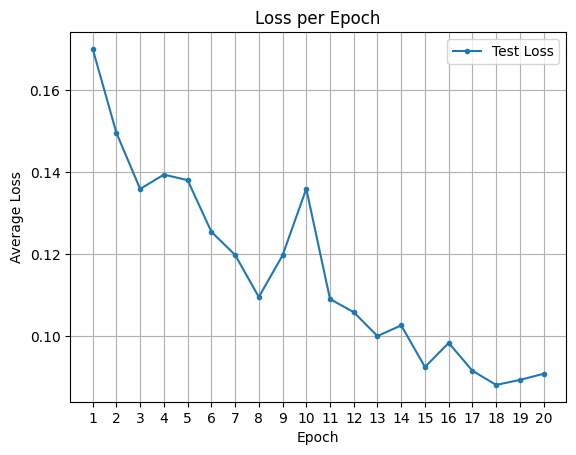

In [34]:
plt.plot(range(1, num_epochs+ 1), avg_losses_test, marker=".", label="Test Loss")
plt.xticks(np.arange(1, num_epochs + 1, 1.0))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

In [43]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    embedding_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Building Embeddings")
        for _, positive, _, labels in progress_bar:
            positive = positive.to(device)
            emb = model(positive).cpu().numpy()
            embeddings.append(emb)
            embedding_labels += list(labels)

    embeddings = np.vstack(embeddings)
    return embeddings, embedding_labels

In [44]:
positive_embeddings, labels = extract_embeddings(embedding_model, test_loader, device)

Building Embeddings: 100%|████████████████████| 747/747 [01:23<00:00,  8.91it/s]


In [46]:
from scipy.spatial import KDTree


def mean_reciprocal_rank(model, loader, positive_embeddings, positive_labels, k=10):
    model.to(device)
    model.eval()

    tree = KDTree(positive_embeddings)

    mrr = 0.0
    num_of_nones = 0
    count = 0
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Counting MRR")
        for anchor, _, _, labels in progress_bar:
            anchor = anchor.to(device)
            anchor_embedding = model(anchor).cpu().numpy()
            distances, batch_indices = tree.query(anchor_embedding, k=k)

            for i, indices in enumerate(batch_indices):  # Перебираем каждый anchor в батче
                label = labels[i]
                rank = 0  

                for r, idx in enumerate(indices, start=1):  # Ищем среди ближайших соседей
                    if positive_labels[idx] == label:  # Нашли первый правильный
                        rank = r
                        break

                if rank > 0:
                    mrr += (1 / rank)
                else:
                    num_of_nones += 1
                count += 1
    
    return (mrr / count), num_of_nones


In [77]:
mrr, num_nones = mean_reciprocal_rank(embedding_model, test_loader, positive_embeddings, labels, k=10)

Counting MRR: 100%|███████████████████████████| 747/747 [15:14<00:00,  1.22s/it]


In [78]:
mrr, num_nones

(0.2080521258105895, 32648)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15560761..0.854748].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.109484285..0.99619406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15560761..0.854748].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15971294..1.1223917].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15560761..0.854748].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07340559..1.0479612].


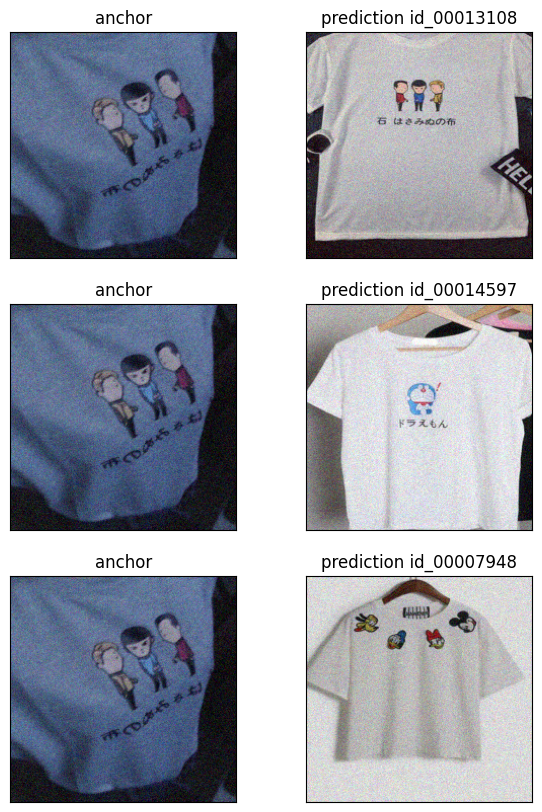

In [150]:
tree = KDTree(positive_embeddings)
fig, axes = plt.subplots(3, 2, figsize=(7, 10))
with torch.no_grad():
    anchor, positive, negative, label = test_dataset[1000]
    anchor = anchor.unsqueeze(0).to(device)
    anchor_embedding = embedding_model(anchor).cpu().numpy()
    dist, indices = tree.query(anchor_embedding, k=3)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    anchor_denormalized = anchor * std + mean
    anchor_denormalized = anchor_denormalized.squeeze(0).cpu().permute(1, 2, 0).numpy()

    for i, idx in enumerate(indices[0]):
        _, positive, _, _ = test_dataset[idx]
        positive = positive.unsqueeze(0).to(device)
        positive_denormalized = positive * std + mean
        positive_denormalized = positive_denormalized.squeeze(0).cpu().permute(1, 2, 0).numpy()

        axes[i, 0].imshow(anchor_denormalized)
        axes[i, 0].set_title("anchor")
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        
        axes[i, 1].imshow(positive_denormalized)
        axes[i, 1].set_title("prediction " + labels[idx])
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])